# Model Training notebook

Contains the whole pipeline to train the models.  
How to use:   

Run the first cells to import all needed models and functions  
Then run the cell that loads the weights, if none are present it will create a new model  
Run the training cell and adjust N and iterations accordingly. Using a higher N will use more RAM, so you can lower N and augment iterations.  
Finally if the results are are good, you can save the model weigths. Only do it if the results are nice, because it overwrites the old weigths. 
The last cell vizualizes 3 different reference images with very different D values. 

In [1]:
# Hyperparameters for simulation
nparticles = 1000   # Number of particles
nframes = 8    # Number of steps in the simulation
nposframe = 10    # Number of position per frame
dt = 0.01        # Integration time frame in second (time between two frames)
DGen = 10000        # Diffusion coefficient in nm^2 per s (=0.001 (um^2)/s)
num_steps = nframes*nposframe
# Hyperparameters for image generation
npixel = 64 # number of image pixels
pixelsize = 100 # in nm 
fwhm_psf = 200 # full width half maximum (emulates microscope)
factor_hr = 5 # image high resulution factor
flux = 100 # number of photons per s
poisson_noise = 100 
gaussian_noise = 10
background = 100 # base background value
normalizeValue = 1000 # value by which all samples will be normalized ! Needs to be fixed and the same for all images !

In [2]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from modelsUtils import *
from simpleCNNModel import *
from ResNetModel import *
from paperCNN import *
import os.path

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [3]:
# Models initialisation
# list of : [name, class, train_fct]

# To add a new model, just write his name, class name (also import the file) and the train_fct used to train it

models_params = {"simpleCNN" : [DiffusionPredictorCNN,train_model],
          "resNet" : [ResNetDiffusionPredictor,train_model],
          "paperCNN" : [PaperCnn,train_model]
}

In [4]:
for name, mlist in models_params.items():
    class_ = mlist[0]
    # Load the model weights
    loaded_model = class_().to(device)
    filename = "weights_"+name+".pth"
    if(os.path.exists(filename)):
        loaded_model = load_model_weights(loaded_model, filename)
        print(name, "Loaded existing weigths")
    else:
        print(name, "Did not find weigths, loaded a new model")
        
    mlist.append(loaded_model)


Model weights loaded from weights_simpleCNN.pth
simpleCNN Loaded existing weigths
Model weights loaded from weights_resNet.pth
resNet Loaded existing weigths
Model weights loaded from weights_paperCNN.pth
paperCNN Loaded existing weigths


In [18]:
# Takes 30 seconds to run with N=100 images (on my laptop)
# Takes 16 seconds to run with N=100 images (on my pc)
# Simulated dataset

iterations = 5
N = 64  # Number of samples per iteration

for i in range(iterations):

    print(f"Generating images for iteration: {i}")

    images, estimatedDs =  generateImagesAndEstimateD(N, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
    #print(images.shape)
    # Add channel dimension to images: (N, 8, 64, 64) -> (N, 8, 1, 64, 64)
    images = torch.tensor(images, dtype=torch.float32).unsqueeze(2)
    estimatedDs = torch.tensor(estimatedDs, dtype=torch.float32)
    #print(images.shape)
    # Initialize the model

    for name, mlist in models_params.items():
        model = mlist[-1]
        train_fct = mlist[1]

        print("Training model:" , name)
        trained_model, loss_history = train_fct(model, images, estimatedDs, device, epochs=1, batch_size=32, learning_rate=0.001)


Generating images for iteration: 0, 
Training model: simpleCNN
Epoch 1/1, Loss: 47413538.0000
Training model: resNet
Epoch 1/1, Loss: 109617020.0000
Training model: paperCNN
Epoch 1/1, Loss: 7218606.0000
Generating images for iteration: 1, 
Training model: simpleCNN
Epoch 1/1, Loss: 36423571.0000
Training model: resNet
Epoch 1/1, Loss: 105650216.0000
Training model: paperCNN
Epoch 1/1, Loss: 2409857.6250
Generating images for iteration: 2, 
Training model: simpleCNN
Epoch 1/1, Loss: 85824938.0000
Training model: resNet
Epoch 1/1, Loss: 191219720.0000
Training model: paperCNN
Epoch 1/1, Loss: 13838402.0000
Generating images for iteration: 3, 
Training model: simpleCNN
Epoch 1/1, Loss: 66294644.0000
Training model: resNet
Epoch 1/1, Loss: 167042504.0000
Training model: paperCNN
Epoch 1/1, Loss: 9450188.0000
Generating images for iteration: 4, 
Training model: simpleCNN
Epoch 1/1, Loss: 94693342.0000
Training model: resNet
Epoch 1/1, Loss: 223073800.0000
Training model: paperCNN
Epoch 1/1

In [14]:
# saves all used models 

for name, mlist in models_params.items():
    model = mlist[-1]
    filename = "weights_"+name+".pth"
    save_model_weights(model,filename)

Model weights saved to weights_simpleCNN.pth
Model weights saved to weights_resNet.pth
Model weights saved to weights_paperCNN.pth


Image loaded from refImageSmall.npy
Real D value for imagerefImageSmall of model: simpleCNN : 1935. Model estimated value: 9894.0
Real D value for imagerefImageSmall of model: resNet : 1935. Model estimated value: 100.0
Real D value for imagerefImageSmall of model: paperCNN : 1935. Model estimated value: 1467.0


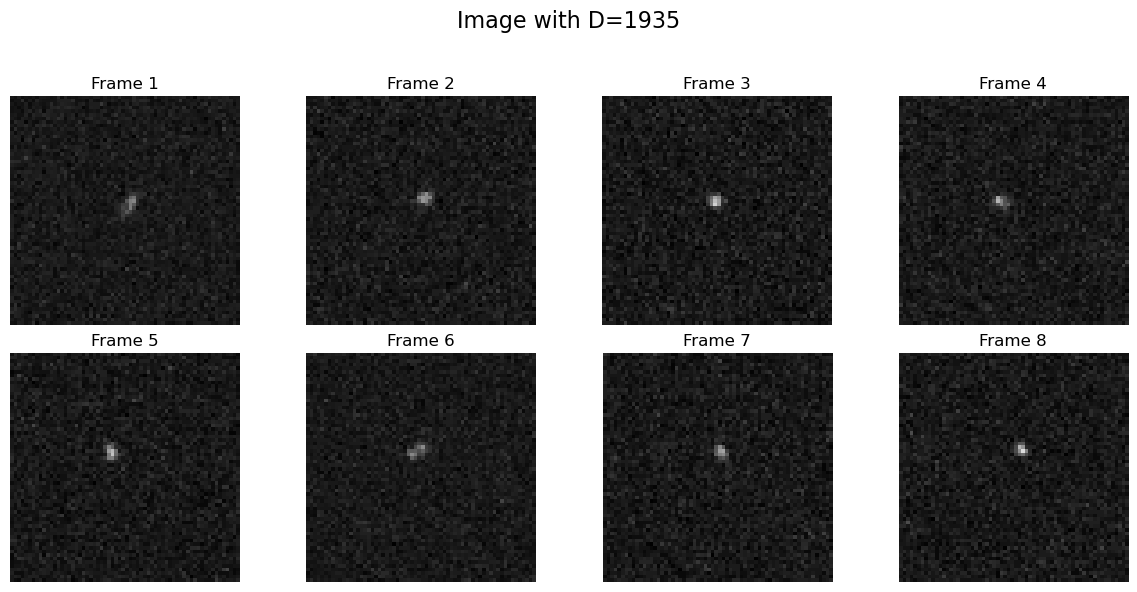

Image loaded from refImage.npy
Real D value for imagerefImage of model: simpleCNN : 13875. Model estimated value: 9894.0
Real D value for imagerefImage of model: resNet : 13875. Model estimated value: 116.0
Real D value for imagerefImage of model: paperCNN : 13875. Model estimated value: 16671.0


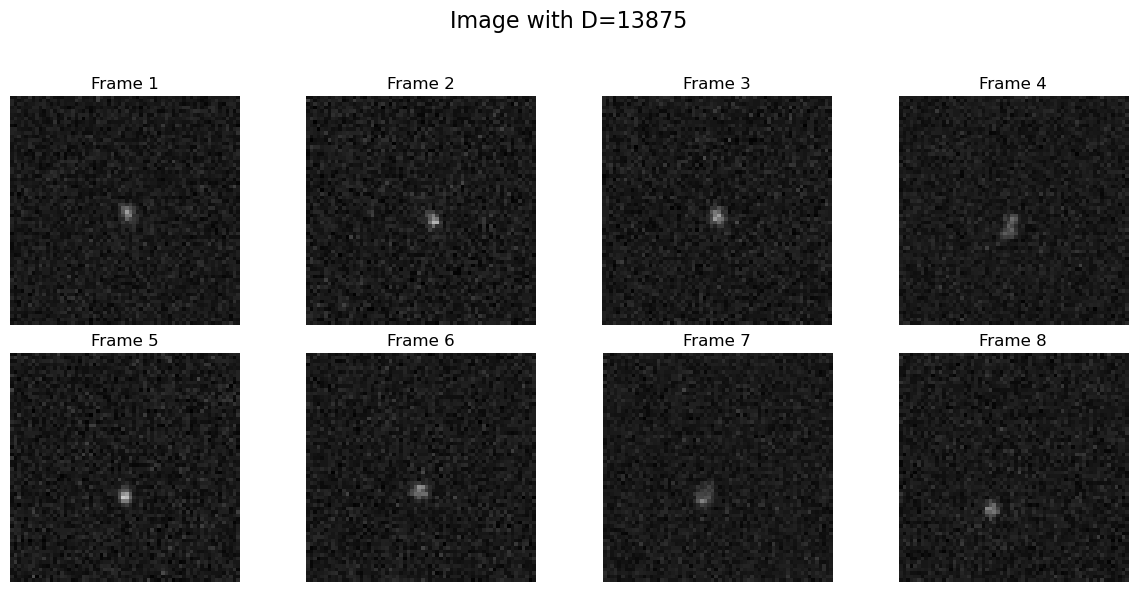

Image loaded from refImageBig.npy
Real D value for imagerefImageBig of model: simpleCNN : 26092. Model estimated value: 9894.0
Real D value for imagerefImageBig of model: resNet : 26092. Model estimated value: 109.0
Real D value for imagerefImageBig of model: paperCNN : 26092. Model estimated value: 26920.0


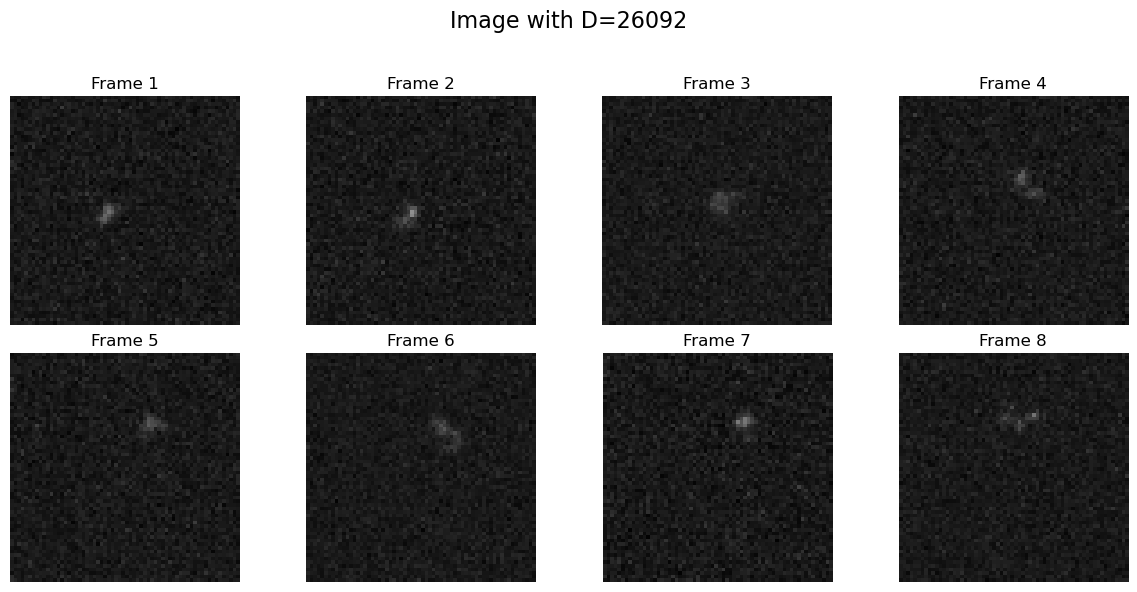

In [5]:
# Uncomment these 3 lines to generate a new reference image
#singleIm, singleestimatedDs = generateImagesAndEstimateD(1, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize,flux, background, poisson_noise, gaussian_noise, normalizeValue)
#im, estD = singleIm[0,:], singleestimatedDs[0]
#save_image(im,"refImageBig.npy") 


# We created 3 reference images, with different D values, to observe what our algorithm predicts
dict = {"refImageSmall": 1935, "refImage": 13875, "refImageBig": 26092}

for iname, estD in dict.items():
    im = load_image(iname + ".npy")
    for mname, mlist in models_params.items():
        model = mlist[-1]

        modelEstimation = predict_diffusion_coefficients(model, im ,device)

        print("Real D value for image" + iname +" of model: "+ mname +f" : {estD}. Model estimated value: {round(modelEstimation,0)}")

    plot_image_frames(im,f"Image with D={estD}")



In [ ]:
# Load the trained model weights
loaded_model = DiffusionPredictorCNN().to(device)
loaded_model = load_model_weights(loaded_model, "diffusion_model_weights.pth")
print("Loaded trained model weights for testing.")

N_test = 20  # Number of test 
test_images, test_estimatedDs = generateImagesAndEstimateD(
    N_test, nframes, npixel, factor_hr, nposframe, DGen, dt, fwhm_psf, pixelsize, flux, background, poisson_noise, gaussian_noise, normalizeValue
)

# Add channel dimension to test images
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(2).to(device)  # Shape: (N_test, 8, 1, 64, 64)
test_estimatedDs = torch.tensor(test_estimatedDs, dtype=torch.float32).to(device)

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_estimatedDs.shape}")

# Predict diffusion coefficients 
predicted_Ds = predict_diffusion_coefficients(loaded_model, test_images, device)

# Compare predictions to ground truth
for i in range(len(predicted_Ds)):
    print(f"Real D: {test_estimatedDs[i].item():.2f}, Predicted D: {predicted_Ds[i]:.2f}")


Model weights loaded from diffusion_model_weights.pth
Loaded trained model weights for testing.
Test images shape: torch.Size([50, 8, 1, 64, 64])
Test labels shape: torch.Size([50])


ValueError: too many values to unpack (expected 5)